## Projet 4 : Construisez un modèle de scoring

## Contexte

Une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin qule e modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un clienée

Notre objectif développer cet algorithme de classificationns.

## Librairies utilisées avec le langage Python:

In [ ]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder # sklearn preprocessing for dealing with categorical variables
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import os

import warnings
warnings.filterwarnings('ignore')

## Données brutes:

Nous avons 10 fichiers CSV :
- application_train.csv : 1 fichier principal pour l'entrainement avec la variable cible
- application_test.csv : 1 fichier principal pour les tests sans la variable cible
- sample_submission.csv : 1 exemple de fichiers de soumission
- HomeCredit_columns_description.csv : 1 fichier expliquant les variables de chaques fichiers
- 6 autres fichiers contenant des informations complémentaires sur chaque prêt.

Nous utiliserons le fichier "application_train.csv" pour l'analyse exploratoire donc visualisons le :

In [ ]:
# Chargement des données brutes du fichier CSV
app_train = pd.read_csv('/tutorial-env/OCR/Projet 4/application_train.csv')
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


##### Nous avons donc un data frame composé de 122 variables dont 65 sont de type flottant, 41 de type entier, et 16 de type objet.
Dans ce data frame, 307511 prêts ont été entrés.

Nous pouvons voir que notre deuxième variable, nommée "TARGET", est notre variable cible binaire que l'on va vouloir prédire (0:payé à temps/1:difficultés de paiement).

Intéressons-nous aux valeurs manquantes de ce dataframe :

In [ ]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables

def show_miss_val(data):
    variables = []
    miss_val = []

    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean()) #Calcul du pourcentage de valeurs manquantes

    # Création d'un dataframe avec le résultat
    output = pd.DataFrame({
        'variable': variables,
        'miss_val': miss_val
    })
    # Affichage d'un message récapitulant le nombre de variables et le nombre d'entre elles qui a des valeurs manquantes
    print ("Notre dataframe a " + str(data.shape[1]) + " variables.\n Il y a " + str(output[output['miss_val']!=0].shape[0]) +" variables contenant des valeurs manquantes.")

    # Retourne les colonnes qui ont des valeurs manquantes avec le pourcentage de valeurs manquantes de chacune d'entre elles
    return output[output['miss_val']!=0].sort_values('miss_val')

In [ ]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable avec un filtre de 0.7 pour n'avoir que les colonnes avec plus de 70% de valeurs manquantes
app_train_vm=show_miss_val(app_train)
app_train_vm.head(70)

Notre dataframe a 122 variables.
 Il y a 67 variables contenant des valeurs manquantes.


,variable,miss_val
95,DAYS_LAST_PHONE_CHANGE,0.000003
29,CNT_FAM_MEMBERS,0.000007
9,AMT_ANNUITY,0.000039
10,AMT_GOODS_PRICE,0.000904
42,EXT_SOURCE_2,0.002146
...,...,...
70,NONLIVINGAPARTMENTS_MODE,0.694330
56,NONLIVINGAPARTMENTS_AVG,0.694330
62,COMMONAREA_MODE,0.698723
48,COMMONAREA_AVG,0.698723


Sur les 122 variables, seules 67 contiennent des valeurs manquantes et aucune ne dépasse les 70% de valeurs manquantes.

## Analyse exploratoire:

### Distribution de la variable cible

La variable cible à prédire est une variable binaire égale à 0 si le prêt est payé en temps et en heure, ou égale à 1 si le client a eu des difficulté à rembourser. Etudions la distribution de notre variable :


In [ ]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: title={'center': 'Distribution de la variable cible "TARGET"'}, xlabel='TARGET', ylabel='count'>

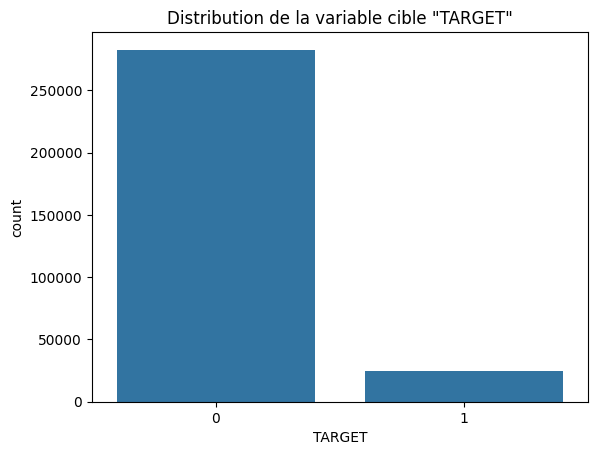

In [ ]:
plt.title(f'Distribution de la variable cible "TARGET"')
sns.countplot(app_train, x="TARGET")

Nous pouvons rapidement identifier que la distribution de notre variable est inégale et qu'il y a beaucoup plus de prêts qui ont été remboursés en temps et en heures que de prêts avec difficultés.

### Variables catégorielles


In [ ]:
app_train.describe(exclude=[np.number])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


La majorité des variables catégorielles ont un nombre relativement petit de valeurs différentes, nous pouvons donc les utiliser facilement en les transformant en variables quantitatives pour qu'elles soient prises en compte par les algorithmes : c'est l'encodage.

La stratégie d'encodage utilisée sera la suivante : pour les variables catégorielles avec 2 catégories uniquement, nous utiliserons le "Label Encoding" et, pour les autres, le "One-Hot Encoding".

In [ ]:
# Label Encoding
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        # Si 2 catégories ou moins
        if len(list(app_train[col].unique())) <= 2:
            # Entrainement sur les données
            le.fit(app_train[col])
            # Transformation sur les données
            app_train[col] = le.transform(app_train[col])
            # Incrémentation du compteur de Label Encoding
            le_count += 1

print('%d colonnes ont été encodés.' % le_count)

3 colonnes ont été encodés.


In [ ]:
# One-Hot Encoding
app_train = pd.get_dummies(app_train)

print('Taille du dataframe encodé : ', app_train.shape)


Taille du dataframe encodé :  (307511, 243)


### Variables quantitatives


In [ ]:
app_train.describe()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.293509,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [ ]:
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Pour vérifier s'il existe des valeurs aberrantes dans la variable "DAYS_BIRTH" transformons-les puisqu'elles sont négatives et en jours. Transformons les en âge en année :

In [ ]:
compt=0
for item in app_train['DAYS_BIRTH'] :
    app_train.loc[compt,'AGE']=item/ (-365)
    compt+=1
app_train['AGE'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE, dtype: float64

Les âges paraissent cohérents et ne pas contenir de valeurs aberrantes. Nous enlevons la colonne "DAYS_BIRTH" qui n'est plus utile.

In [ ]:
app_train=app_train.drop('DAYS_BIRTH',axis=1)

Etudions la variable "DAYS_EMPLOYED" maintenant :

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

La variable correspond au nombre de jours où la personne a commencé son emploi actuel avant de candidater au prêt. La valeur maximale est aberrante puisqu'elle est positive. Etudions cette variable de plus près :

Text(0.5, 0, "Nombre de jours d'ancienneté dans le dernier emploi")

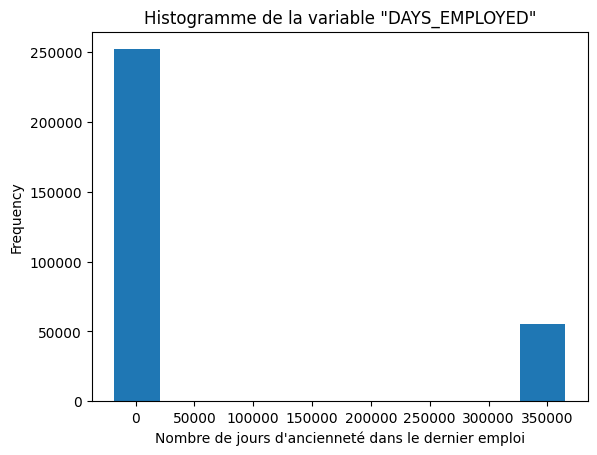

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme de la variable "DAYS_EMPLOYED"');
plt.xlabel('Nombre de jours d\'ancienneté dans le dernier emploi')

Voyons si les clients anormaux avec un nombre de jours d'ancienneté égal à 365243 ont tendance à avoir un taux de défaut de paiement plus élevés ou plus faible que le reste des clients.

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Le taux de défaut de paiement des clients normaux est de %0.2f%% ' % (100 * non_anom['TARGET'].mean()))
print('Le taux de défaut de paiement des clients anormaux est de %0.2f%% ' % (100 * anom['TARGET'].mean()))
print('Il y a  %d clients anormaux' % len(anom))

Le taux de défaut de paiement des clients normaux est de 8.66% 
Le taux de défaut de paiement des clients anormaux est de 5.40% 
Il y a  55374 clients anormaux


Le taux est différents entre les deux groupes. Peut-être que ces anomalies qui ont exactement la même valeur on quelque chose en commun qui a une certaine importance. Nous décidons donc de les remplir avec la même valeur "NaN" et de créer une nouvelle colonne booléenne indiquant si la valeur initiales était anormale ou non.

Text(0.5, 0, 'Days Employment')

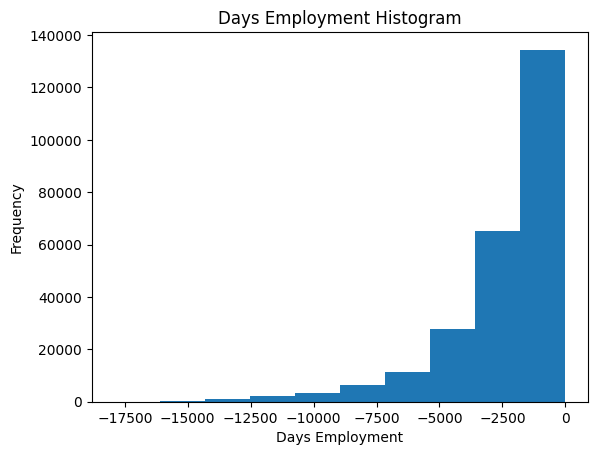

In [ ]:
# Creation de la variable booléenne indiquant si la valeur initiale de "DAYS_EMPLOYED" était anormale ou non
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Imputation en NaN des valeurs anormales
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

Il semble qu'aucune autre valeur aberrante dans les autres variables quantitatives n'apparait de façon évidente. Recherchons des duplicatas éventuelsdans les ID de prêts :

In [ ]:
app_train.duplicated(subset=['SK_ID_CURR']).sum()

0

Aucun duplicata n'apparait.

### Corrélations


Traçons la matrice de corrélations pour avoir une idée des relations possibles entre les variables quantitatives et notre variable cible.

En termes de valeurs, voici les tendances en terme d'interprétation :
- 0 à 0.19 : "très faible"
- 0.2 à 0.39 : "faible"
- 0.4 à 0.59 : "modérée"
- 0.6 à 0.79 : "forte"
- 0.8 à 1 : "très forte"

In [ ]:
correlations = app_train.corr()['TARGET'].sort_values()

# Affichage du top 15 des corrélations positives et négatives avec notre variable cible
print('TOP 15 des Corrélations Positives:\n', correlations.tail(15))
print('\nTOP 15 des Corrélations Négatives:\n', correlations.head(15))

TOP 15 des Corrélations Positives:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
TARGET                                               1.000000
Name: TARGET, dtype: float64

TOP 

Aucun calcul de corrélations ne dépasse |0.2|, elles sont donc toutes considérées comme très faibles.

Les valeurs de corrélations les plus importantes sont négatives et proviennent des 3 variables "EXT_SOURCE" et de notre nouvelle variable "AGE". Ainsi plus ces variables ont des valeurs élevées, plus la valeur de "TARGET" tend à se rapprocher de 0, donc de paiement en temps et en heures.

Etudions un peu plus la variable "AGE" :

<Axes: title={'center': 'Distribution de la variable cible "AGE"'}, xlabel='AGE', ylabel='Count'>

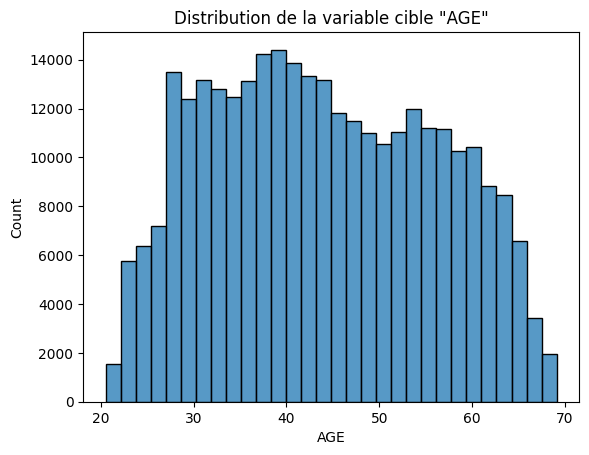

In [ ]:
plt.title(f'Distribution de la variable cible "AGE"')
sns.histplot(app_train, x="AGE",bins = 30)

Traçons maintenant le KDE ou Estimation par Noyau :

<Axes: xlabel='AGE', ylabel='Density'>

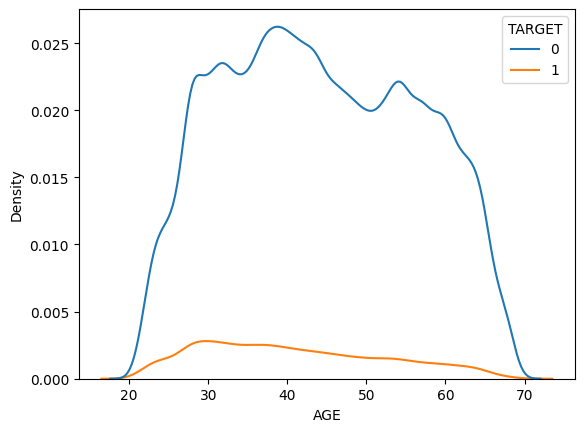

In [ ]:
sns.kdeplot(data=app_train, x='AGE', hue='TARGET')

Comme les données sont déséquilibrées, on trace les KDE en fonction de chaque groupe afin de s'affranchir de ce déséquilibre.

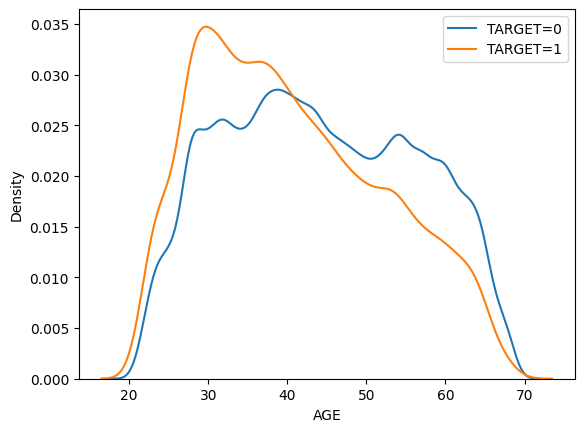

In [ ]:
# Courbe KDE  des clients qui paient en temps et en heures
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'AGE'],label='TARGET=0' )

# Courbe KDE  des clients qui ont des difficultés de paiement
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'AGE'],label='TARGET=1' )
plt.legend()

On visualise que les clients ayant des difficultés de paiement (courbe orange) ont une tendance à être plus jeune même s'il n'y a pas de corrélation significative. Cependant, cela peut affecter le modèle de Machine Learning.

Traçons la moyenne de défaut de paiement par tranche d'âge. Pour cela, on commence par séparer la variable de l'âge par tranches de 5 ans et on calcule la moyenne de la variable cible 'TARGET' pour avoir le ratio de défaut de paiment pour chaque tranche d'âge.

In [ ]:
# Création d'un dataframe séparé avec les variables Target et Age
age_data = app_train[['TARGET', 'AGE']]

# Séparation de l'âge en intervalle
age_data['AGE'] = pd.cut(age_data['AGE'], bins = np.linspace(20, 70, 11))
age_data.head(10)

,TARGET,AGE
0,1,"(25.0, 30.0]"
1,0,"(45.0, 50.0]"
2,0,"(50.0, 55.0]"
3,0,"(50.0, 55.0]"
4,0,"(50.0, 55.0]"
5,0,"(45.0, 50.0]"
6,0,"(35.0, 40.0]"
7,0,"(50.0, 55.0]"
8,0,"(55.0, 60.0]"
9,0,"(35.0, 40.0]"


In [ ]:
# Regroupement des intervalles et calcul des moyennes
age_groups  = age_data.groupby('AGE').mean()
age_groups

,TARGET
AGE,
"(20.0, 25.0]",0.123036
"(25.0, 30.0]",0.111436
"(30.0, 35.0]",0.102814
"(35.0, 40.0]",0.089414
"(40.0, 45.0]",0.078491
"(45.0, 50.0]",0.074171
"(50.0, 55.0]",0.066968
"(55.0, 60.0]",0.055314
"(60.0, 65.0]",0.052737


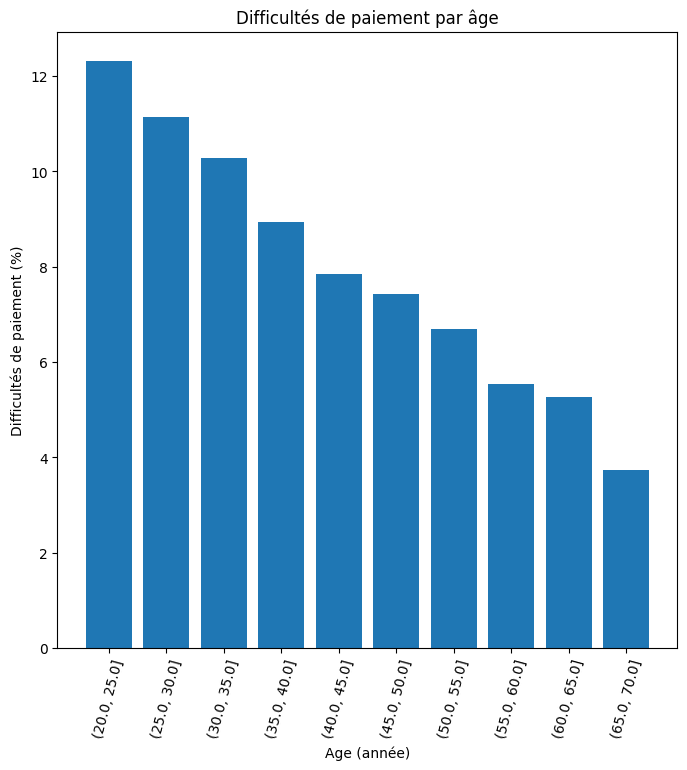

In [ ]:
#  Graphique de la moyenne par intervalle d'âge
plt.figure(figsize = (8, 8))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age (année)'); plt.ylabel('Difficultés de paiement (%)')
plt.title('Difficultés de paiement par âge');

On peut voir qu'en effet plus les clients sont jeunes, plus le taux de défaut de paiement est élevé.

Cette information peut être utile pour la banque et, sans discriminer les clients jeunes, des précautions supplémentaires peuvent être mis en place pour aider les clients jeunes à payer en temps et en heures.

Etudions un peu plus les variables "EXT_SOURCE_1", "EXT_SOURCE_2", et "EXT_SOURCE_3" qui ont les corrélations les plus élevées. Selon la documentation, elles représentent des scores normalisés de données sources externes. La formulation n'est pas très précise mais elles correspondent peut-être à une sorte de notation de crédit cumulée à partir de nombreuses sources de données.

Commençons par regarder les corrélation de ces trois variables entre elles et avec la variable cible :

In [ ]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
AGE,-0.078239,0.600610,0.091996,0.205478,1.000000


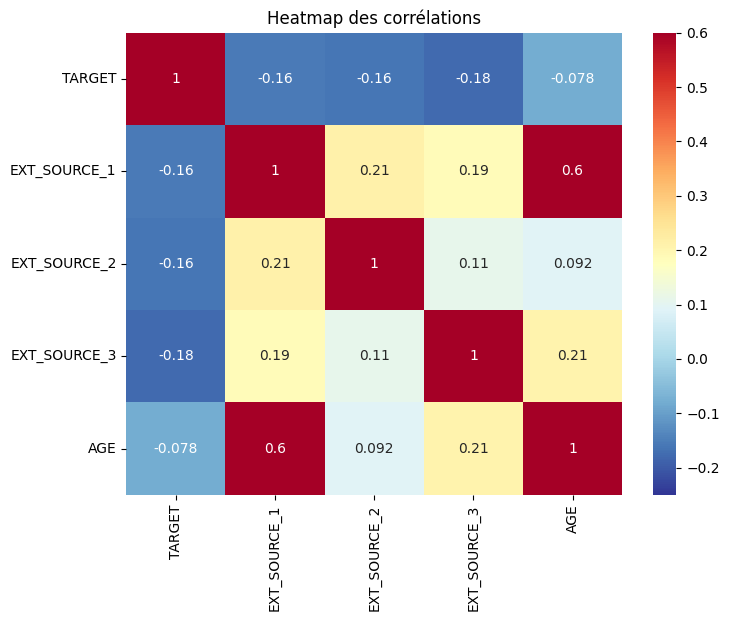

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap des correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap des corrélations');

Nous pouvons voir que la variable "EXT_SOURCE_1" est corrélée fortement avec la variable "AGE". On peut donc supposer qu'un des facteurs de ce score "EXT_SOURCE_1" est l'âge du client.

Les autres corrélations sont faibles : les 3 variables "EXT_SOURCE" sont corrélées positivement entre elles, les 3 variables "EXT_SOURCE" sont corrélées négativement avec la variable cible "TARGET".

Regardons la distribution de ces variables en fonction de la variable cible "TARGET" :

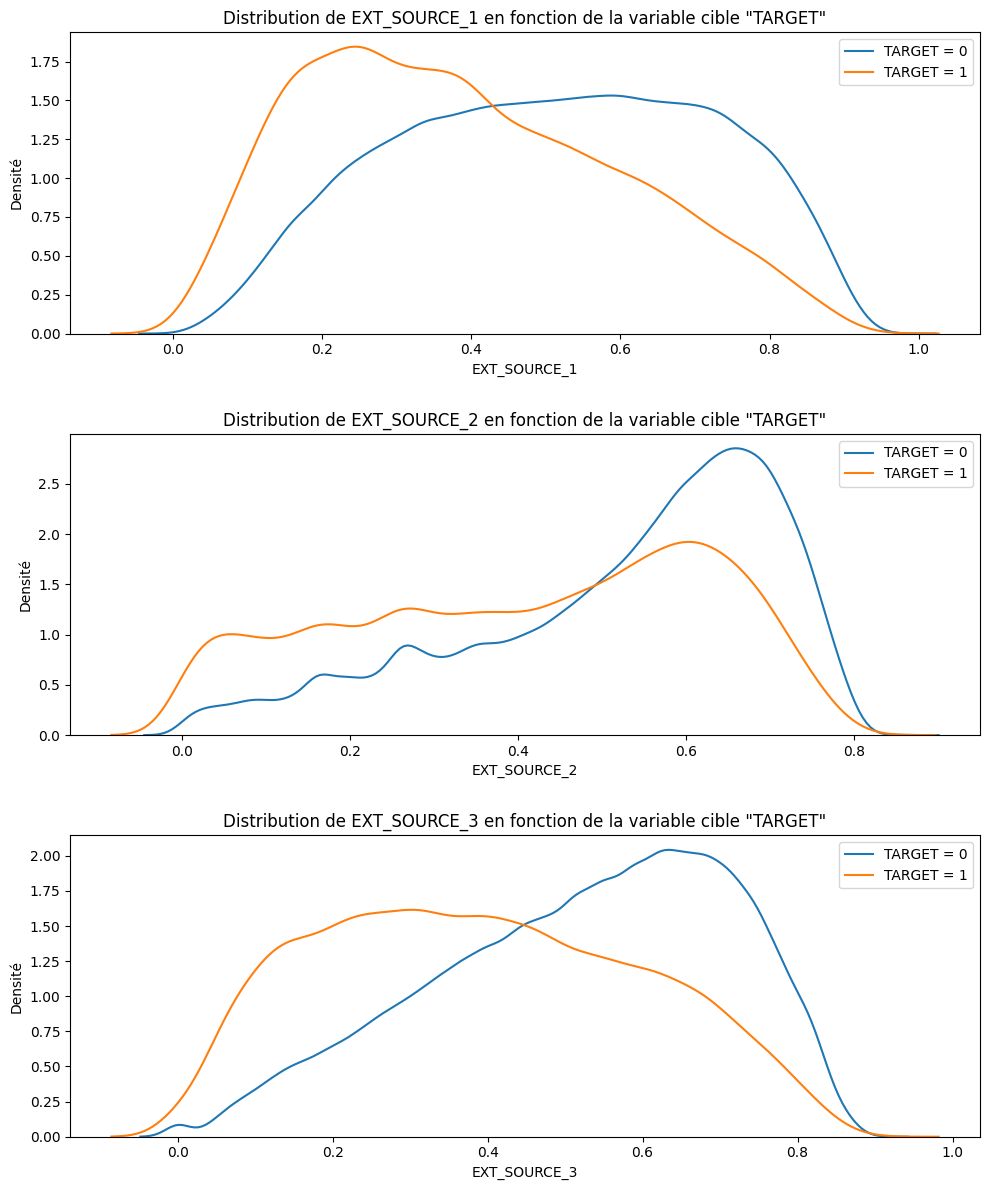

In [ ]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'TARGET = 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'TARGET = 1')

    plt.title('Distribution de %s en fonction de la variable cible "TARGET"' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densité');
    plt.legend()

plt.tight_layout(h_pad = 2.5)


La variable "EXT_SOURCE_3" montre la plus grande différence en fonction de la variable cible "TARGET". On peut donc considérer que cette variable a un lien avec la probabilité de remboursement d'un client. La variable "EXT_SOURCE_1" a également probablement un lien avec l'âge puisque la distribution diffère en fonction de la variable cible.

Malgré les faibles taux de corrélations, ces liens peuvent avoir un effet sur les modèles de Machine Learning pour la prédiction de la variable cible.

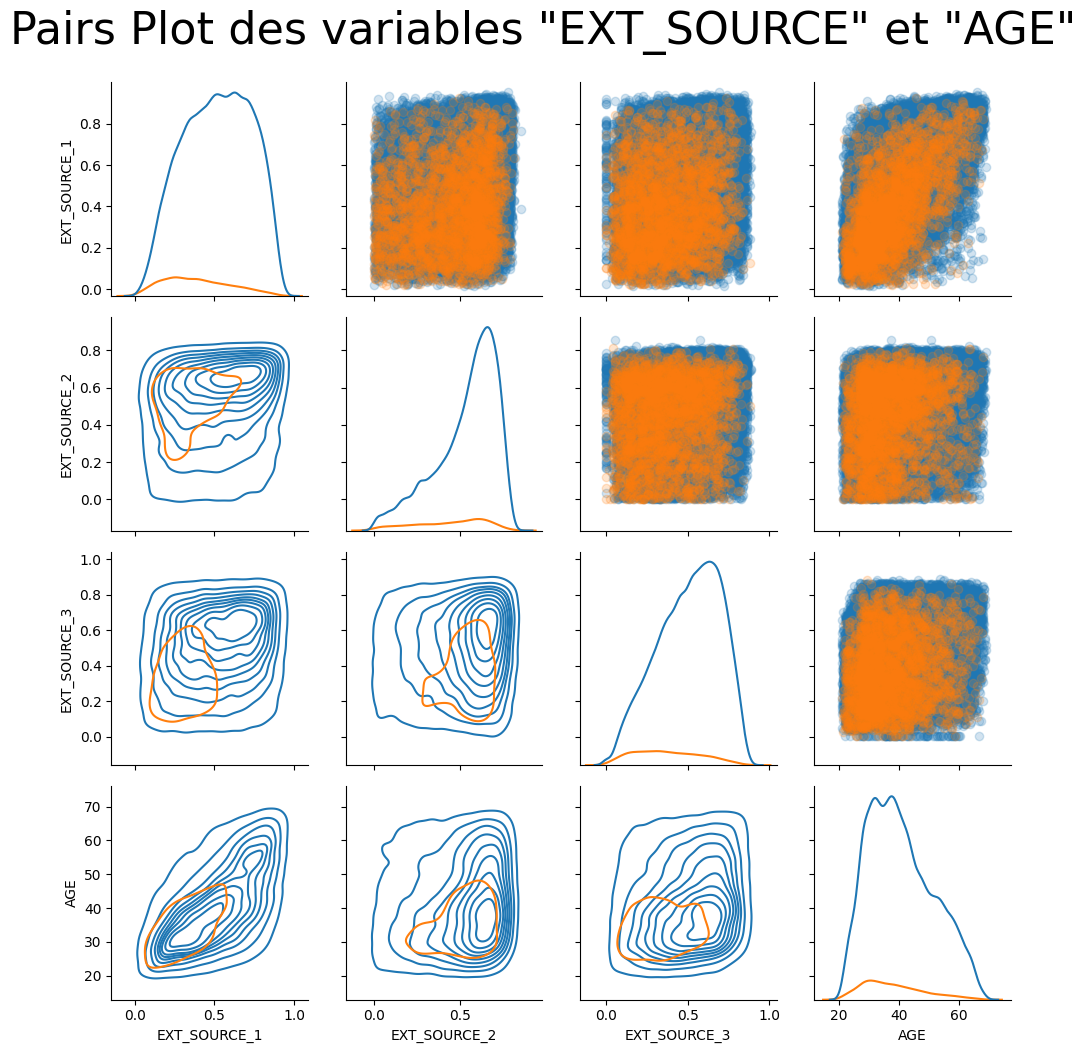

In [ ]:
# Rejet des valeurs manquantes NaN et limitation aux 100000 premières lignes
ext_data_clean = ext_data.dropna().loc[:100000, :]

# Fonction pour calculer le coefficient de corrélation entre deux colonnes
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Creation de l'objet pairgrid
grid = sns.PairGrid(data = ext_data_clean, diag_sharey=False,
                    hue = 'TARGET',
                    vars = [x for x in list(ext_data.columns) if x != 'TARGET'])

#  scatter plot en haut à droite
grid.map_upper(plt.scatter, alpha = 0.2)

# histogramme dans la diagonale
grid.map_diag(sns.kdeplot)

# density plot en bas à gauche
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Pairs Plot des variables "EXT_SOURCE" et "AGE"', size = 32, y = 1.05);

Nous confirmons les observations déjà réalisées : Les variables "EXT_SOURCE_1" et "EXT_SOURCE_3" semblent avoir pour facteur l'âge du client.

## Feature Engineering:

C'est un processus impliquant la création de nouvelles variables et la sélection de variables pertinentes. Ici, nous testerons deux méthodes : la polynomiales et celle liée à la connaissance du domaine métier.

### Méthode polynomiales

C'est une méthode basée sur la combinaison de variables initiales et/ou l'élévation à la puissance 2. Ainsi des variables initiales n'ayant pas de forts liens avec la variable cible, peuvent, une fois combinées, montrer une relation plus importante.

Pas forcément très utilisé en Machine Learning, nous tenterons de créer de nouvelles variables à partir des variables "EXT_SOURCE" et "AGE" via cette méthode en utilisant la méthode PolynomialFeatures avec un degré 3 ( l'augmentation du degré augmente exponentiellement le nombre de variables et peut poser un problème d'overfitting).

Commençons par imputer les valeurs manquantes pour pouvoir utiliser cet méthode de feature Engineering :

In [ ]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')

poly_target = ext_data['TARGET']
ext_data = ext_data.drop(columns = ['TARGET'])

for i in ext_data.columns:
    # Remodeler la colonne en un tableau 2D
    data_temp = ext_data[i].values.reshape(-1, 1)

    # Imputer les valeurs manquantes
    data_temp_imp = imputer.fit_transform(data_temp)

    # Mettre à jour le DataFrame avec les valeurs imputées
    ext_data[i] = data_temp_imp

ext_data.isna().mean()

EXT_SOURCE_1    0.0
EXT_SOURCE_2    0.0
EXT_SOURCE_3    0.0
AGE             0.0
dtype: float64

Maintenant que notre dataframe ne contient plus de valeurs manquantes, utilisons l'objet polynomial :

In [ ]:
# Creation de l'objet polynomial de degré 3
poly_transformer = PolynomialFeatures(degree = 3)

# Entrainement  et transformation de la méthode polynomiale
poly_transformer.fit(ext_data)
ext_data = poly_transformer.transform(ext_data)

print(' Taille de la méthode Polynomiale : ', ext_data.shape)

 Taille de la méthode Polynomiale :  (307511, 35)


In [ ]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE'])

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 AGE', 'EXT_SOURCE_2^2',
       'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 AGE', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 AGE', 'AGE^2', 'EXT_SOURCE_1^3',
       'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3',
       'EXT_SOURCE_1^2 AGE', 'EXT_SOURCE_1 EXT_SOURCE_2^2',
       'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_1 EXT_SOURCE_2 AGE', 'EXT_SOURCE_1 EXT_SOURCE_3^2',
       'EXT_SOURCE_1 EXT_SOURCE_3 AGE', 'EXT_SOURCE_1 AGE^2',
       'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3',
       'EXT_SOURCE_2^2 AGE', 'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 AGE', 'EXT_SOURCE_2 AGE^2',
       'EXT_SOURCE_3^3', 'EXT_SOURCE_3^2 AGE', 'EXT_SOURCE_3 AGE^2',
       'AGE^3'], dtype=object)

Nous avons maintenant un dataframe de 35 variables avec les variables initiales et leurs combinaisons polynomiales de degré 3. Regardons maintenant si ces nouvelles variables sont corrélées avec la variable cible "TARGET" :

In [ ]:
# Creation du dataframe contenant les nouvelles variables avec leurs valeurs
ext_data = pd.DataFrame(ext_data,
                             columns = poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE']))

# Ajoutons la variable cible
ext_data['TARGET'] = poly_target

# Etudions les corrélations avec cette variable cible
poly_corrs = ext_data.corr()['TARGET'].sort_values()

# Affichage des 10  corrélations les plus positives et négatives
print(poly_corrs.head(10))
print(poly_corrs.tail(10))


EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 AGE            -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 AGE                         -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
EXT_SOURCE_1         -0.098887
EXT_SOURCE_1^2 AGE   -0.097507
EXT_SOURCE_1 AGE^2   -0.094913
EXT_SOURCE_1^2       -0.091034
EXT_SOURCE_1^3       -0.083005
AGE                  -0.078239
AGE^2                -0.076672
AGE^3                -0.074273
TARGET                1.000000
1                          NaN
Name: TARGET, dtype: float64


Plusieurs nouvelles variables sont plus corrélées négativement à la variable cible que les variables initiales. En Machine Learning, il est possible d'essayer avec ou sans ces nouvelles variables pour déterminer si elles apportent réellement une plus-value ou non.

Nous allons donc créer un nouveau dataframe avec ces nouvelles variables pour qu'on puisse également évaluer les modèles avec ces nouvelles variables.

In [ ]:
# Fusion des nouvelles variables polynomiales dans le dataframe d'entrainement
ext_data['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(ext_data, on = 'SK_ID_CURR', how = 'left',copy=False)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)

Training data with polynomial features shape:  (307511, 280)


Le dataframe après la méthode polynomiales comprend 280 variables.

### Méthode liée à la connaissance métier

Créons de nouvelles variables qui sont importantes pour savoir si un client remboursera ou non son prêt :
- CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport aux revenus d'un client
- ANNUITY_INCOME_PERCENT : le pourcentage de la rente du prêt par rapport aux revenus d'un client
- CREDIT_TERM : la durée du versement en mois (puisque la rente est le montant mensuel dû)
- DAYS_EMPLOYED_PERCENT : le pourcentage de jours employés par rapport à l'âge du client

In [ ]:
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] /( app_train_domain['AGE']* (-365))

Visualisons ces nouvelles variables en fonction de la variable cible "TARGET" :

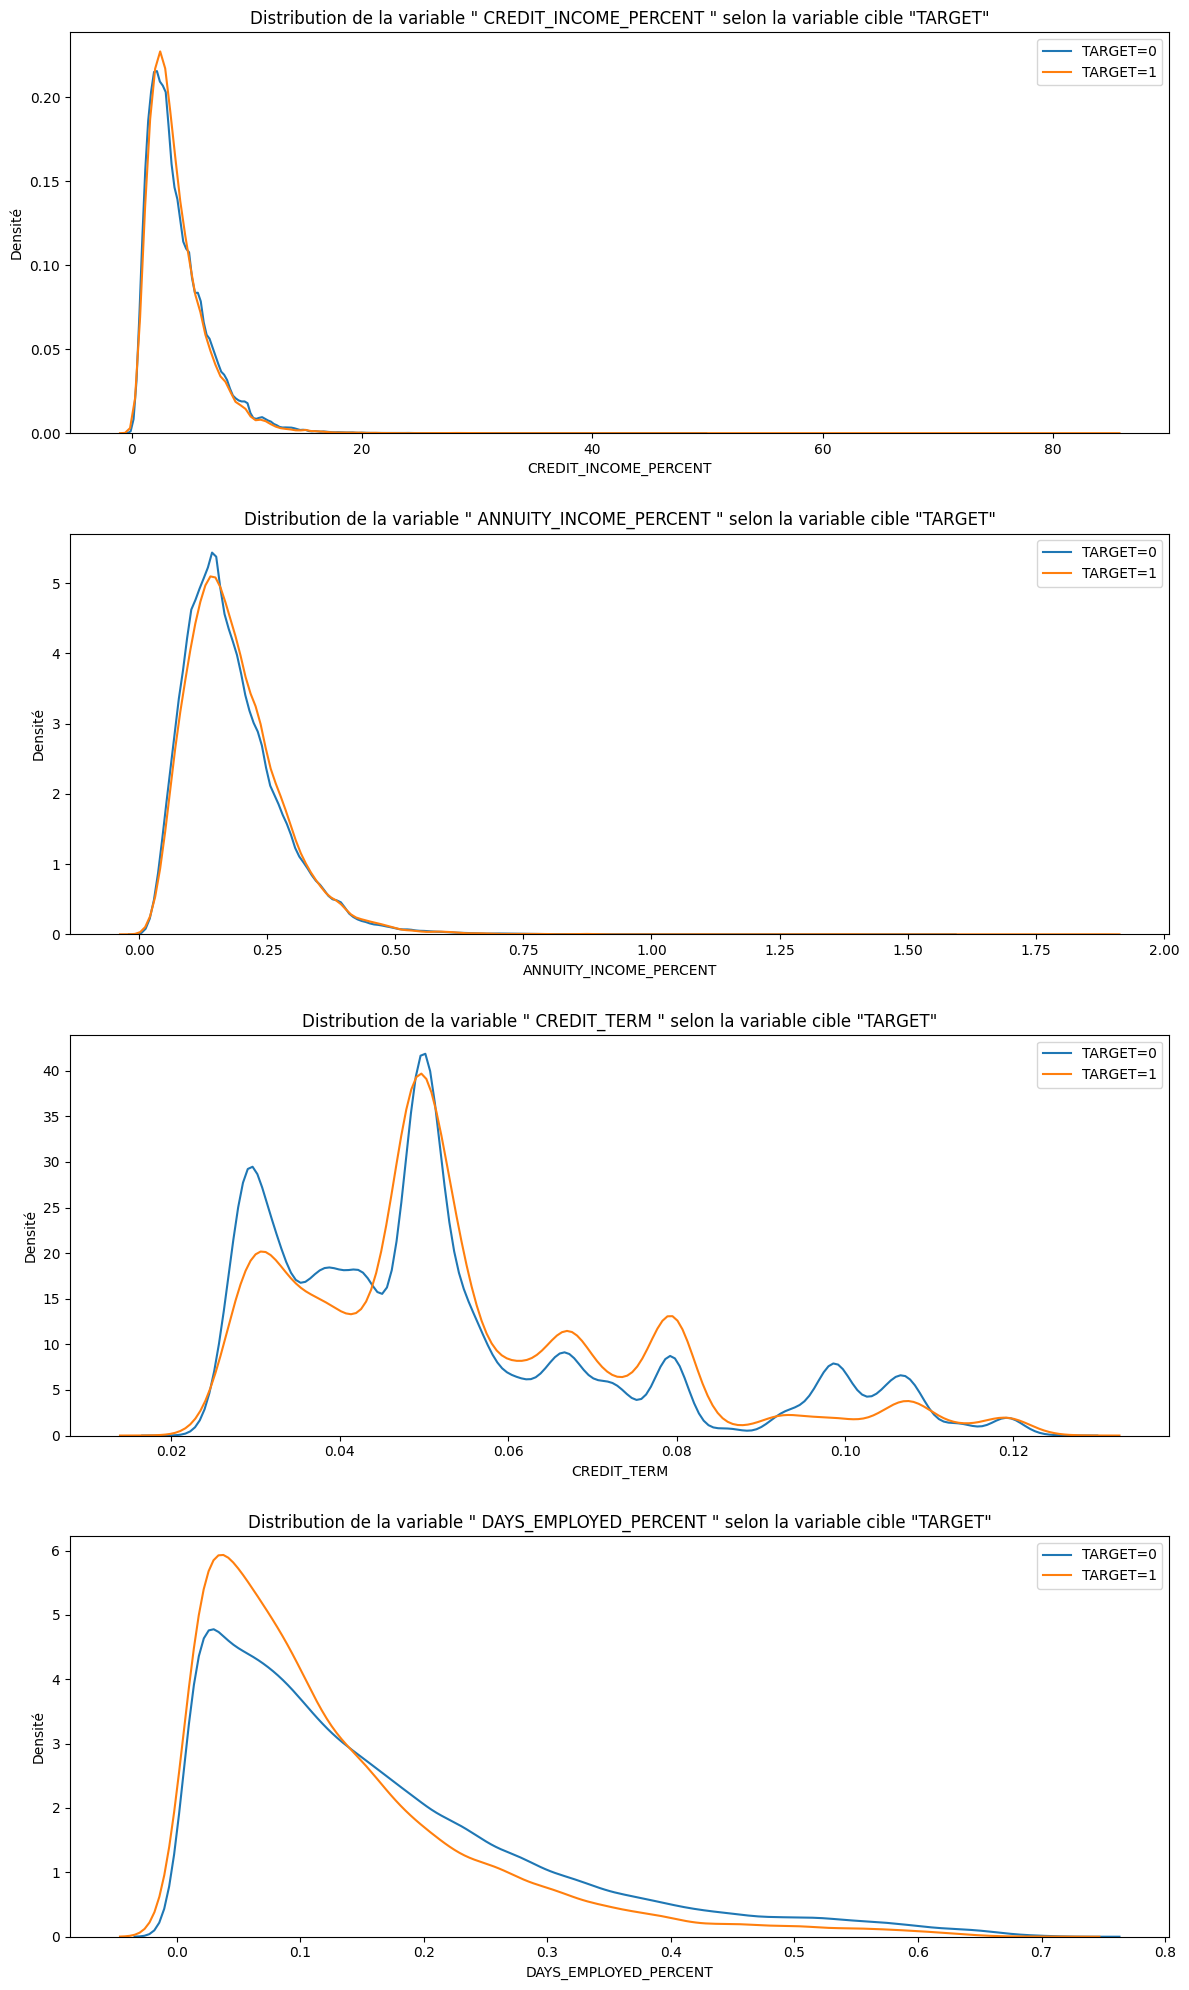

In [ ]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    # creation d'une figure pour chaque nouvelle variable
    plt.subplot(4, 1, i + 1)
    # graphique KDE pour les prêts remboursés
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature],label='TARGET=0')
    # graphique KDE pour les prêts non remboursés
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature],label='TARGET=1')

    plt.title('Distribution de la variable " %s " selon la variable cible "TARGET"' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Densité')
    plt.legend()

plt.tight_layout(h_pad = 2.5)

Créons maintenant un dataframe complet avec toutes les nouvelles variables issues des deux approches de feature engineering :

In [ ]:
app_train_featengin = app_train_poly.copy()
app_train_featengin['CREDIT_INCOME_PERCENT']=app_train_domain['CREDIT_INCOME_PERCENT']
app_train_featengin['ANNUITY_INCOME_PERCENT']=app_train_domain['ANNUITY_INCOME_PERCENT']
app_train_featengin['CREDIT_TERM']=app_train_domain['CREDIT_TERM']
app_train_featengin['DAYS_EMPLOYED_PERCENT']=app_train_domain['DAYS_EMPLOYED_PERCENT']
app_train_featengin

,SK_ID_CURR,TARGET_x,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_2 AGE^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 AGE,EXT_SOURCE_3 AGE^2,AGE^3,TARGET_y,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,176.668535,0.002707,0.503522,93.643075,17415.363116,1,2.007889,0.121978,0.060749,0.067329
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1312.753979,0.153368,13.160326,1129.274084,96901.852559,0,4.790750,0.132217,0.027598,0.070862
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,1513.658643,0.388325,27.774159,1986.492037,142079.933974,0,2.000000,0.100000,0.050000,0.011814
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,1763.430666,0.153368,14.918699,1451.202419,141164.348604,0,2.316167,0.219900,0.094941,0.159905
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,962.424162,0.153368,15.646383,1596.224612,162844.855121,0,4.222222,0.179963,0.042623,0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,445.090609,0.153368,7.321584,349.523354,16685.811649,0,1.617143,0.174971,0.108198,0.025303
307507,456252,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,375.772198,0.153368,16.308128,1734.100689,184393.031346,0,3.743750,0.166687,0.044524,NaN
307508,456253,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,900.668623,0.010483,1.964002,367.951287,68934.817362,0,4.429176,0.195941,0.044239,0.529266
307509,456254,1,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,552.140903,0.288836,14.318861,709.849330,35190.373617,1,2.164368,0.118158,0.054592,0.400134


Notre dataframe définitif fait 307511 lignes et contient 284 variables.

## Sélection des variables

Nous allons supprimer certaines variables pour diminuer le temps d'entrainement et de prédiction de nos modèles.

Supprimons la variable "SK_ID_CURR" qui est juste un identifiant et la variable "1" qui est juste la combinaison polynomiale d'ordre 0. Toutes deux n'ont pas d'impact sur l'analyse.

De même, supprimons les colonnes qui ont été doublés lors de la fusion des nouvelles variables polynomiales dans le dataframe d'entrainement.

In [ ]:
app_train_featengin = app_train_featengin.drop( columns=["SK_ID_CURR", "1",'EXT_SOURCE_1_y', 'EXT_SOURCE_2_y', 'EXT_SOURCE_3_y', 'AGE_y'])
app_train_featengin.shape

(307511, 278)

Séparons notre dataframe de 2787 variables dorénavant  en deux : une partie train et une partie test

In [ ]:
X = app_train_featengin.drop( columns = ['TARGET_x','TARGET_y'])
y = app_train_featengin['TARGET_x']
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Préparation des données et enregistrement des dataframes de modélisation

Imputons les valeurs manquantes pour pouvoir faire tourner les algorithmes de modélisation :

In [ ]:
# Créer une instance de SimpleImputer
imputer = SimpleImputer(strategy='median')

for i in X_train.columns:
    # Remodeler la colonne en un tableau 2D
    data_temp_train = X_train[i].values.reshape(-1, 1)
    data_temp_test = X_test[i].values.reshape(-1, 1)

    # Imputer les valeurs manquantes (entrainement de l'imputer seulement sur les données d'entrainement pour éviter la fuite de données)
    data_temp_imp_train = imputer.fit_transform(data_temp_train)
    data_temp_imp_test = imputer.transform(data_temp_test)

    # Mettre à jour le DataFrame avec les valeurs imputées
    X_train[i] = data_temp_imp_train
    X_test[i] = data_temp_imp_test

In [ ]:
show_miss_val(X_train)

Notre dataframe a 276 variables.
 Il y a 0 variables contenant des valeurs manquantes.


,variable,miss_val


In [ ]:
X_train.to_csv('D:/tutorial-env/OCR/Projet 4/X_train.csv', index=False)
X_test.to_csv('D:/tutorial-env/OCR/Projet 4/X_test.csv', index=False)
y_train.to_csv('D:/tutorial-env/OCR/Projet 4/y_train.csv', index=False)
y_test.to_csv('D:/tutorial-env/OCR/Projet 4/y_test.csv', index=False)